In [204]:
import numpy as np
import pandas as pd
from utils import strike_from_fwd_delta,strike_from_spot_delta

### SABR model

Hagan, Kumar, Lesniewski,and Woodward (2002) propose a stochastic volatility model that
models the forward price of a single asset (LIBOR, swap rate etc.) under the assets canonical
measure, with a stochastic volatility of the said asset, denoted as $\sigma$. As a result, it is a two-factor
model where both $F_t$ and $\sigma_t$ are stochastic variables that develop over time by the following
system of stochastic differential equations:

## SABR Model: Normal Volatility Function

The normal volatility function Hagan formula (Hagan et al., 2002) is defined as:


$$\sigma(k, f, t, \alpha, \beta, \nu, \rho) = A(k, f, t, \alpha, \beta, \nu, \rho) \cdot B(k, f, t, \alpha, \beta, \nu, \rho) \cdot \frac{\zeta}{\chi(\zeta)}$$

### Function A

$$
A(k, f, t, \alpha, \beta, \nu, \rho) = \left(1 + \left(\frac{(1-\beta)^2}{24} \frac{\nu^2}{f_{\text{av}}} + \frac{\rho \alpha \beta \nu}{4 \sqrt{f_{\text{av}}}} + \frac{(2-3\rho^2) \alpha^2}{24}\right)t \right)
$$

where 

$$
f_{\text{av}} = (f \cdot k)^{1 - \beta}
$$

### Function B

$$
B(k, f, t, \alpha, \beta, \nu, \rho) = \frac{\nu}{f_{\text{av}}^{1/2} \left(1 + \frac{(1-\beta)^2}{24} \ln^2\left(\frac{f}{k}\right) + \frac{(1-\beta)^4}{1920} \ln^4\left(\frac{f}{k}\right)\right)}
$$


### Function $\frac{\zeta}{\chi(\rho,\zeta)}$

$$
\frac{\zeta}{\chi(\zeta)} = \frac{\alpha (f_{\text{av}}^{1/2}) \ln\left(\frac{f}{k}\right)}{\nu} \cdot \frac{1}{\chi(\rho, \zeta)}
$$

### Function $\chi(\rho, \zeta)$

$$
\chi(\rho, \zeta) = \ln\left(\frac{\sqrt{1 - 2\rho \zeta + \zeta^2} + \zeta - \rho}{1 - \rho}\right)
$$


In [225]:
def normal_vol(k, f, t, alpha, beta, nu,rho):


    return  A(k, f, t, nu, beta, alpha,rho)*B(k, f, t, nu, beta, alpha,rho)*_zeta_over_x_of_zeta(k, f, t, nu, beta, rho, alpha)


def A(k, f, t, nu, beta, alpha,rho):
    f_av = f * k
    f_av = (f_av ** (1 - beta))
    b=(1+((1-beta)**2/24*alpha**2/f_av+rho*nu*beta*alpha/(4*np.sqrt(f_av))+(2-3*rho**2)*nu**2/24)*t)
    return b
def B(k, f, t, nu, beta, alpha,rho):
    f_av = np.sqrt(f * k)
    f_av = (f_av ** (1 - beta))
    lnfk=np.log(f/k)**2
    b=f_av*(1+(1-beta)**2/24*lnfk+(1-beta)**4/1920*lnfk**2)
    return alpha/b


def _zeta_over_x_of_zeta(k, f, t, nu, beta, rho, alpha):


    f_av = np.sqrt(f * k)
    z = nu * (f_av**(1-beta))*np.log(f/k) / alpha

    return z / chi(rho, z)



def chi(rho, z):

    a = np.sqrt(1 - 2*rho*z + z**2) + z - rho
    b = 1 - rho
    return np.log(a / b)


### Obłój’s refinement of the SABR model

Obłój (2008) claims that the Hagan formula is known to produce incorrect prices when strikes
are low and maturities are long. To fix this problem, he proposed a correction which is now
called Obłój’s refinement.
Obłój’s refinement can be summed up in these formulae

$$ \sigma(t,k)=I_0H(\alpha, \beta, \rho, \nu, f, k)*(1+I_1H(\alpha, \beta, \rho, \nu, f, k))*t)$$
where
$$I_1H(\alpha, \beta, \rho, \nu, f, k) = \frac{(\beta-1)^2 \alpha^2}{24 (f k)^{1-\beta}} + \frac{\alpha \rho \nu \beta}{4 (f k)^{(1-\beta)/2}} + \frac{\nu^2 (2 - 3 \rho^2)}{24}
$$

and 

$$I_0H(\alpha, \beta, \rho, \nu, f, k) = 
\begin{cases} 
\alpha k^{\beta-1} & \text{if } \frac{f}{k} = 1 \\ 
\frac{\log\left(\frac{f}{k}\right) \alpha (1-\beta)}{f^{1-\beta} - k^{1-\beta}} & \text{if } \nu = 0 \\ \\
\frac{\nu \log\left(\frac{f}{k}\right)}{\log\left(\frac{\sqrt{1 - 2 \rho z_2 + z_2^2} + z_2 - \rho}{1 - \rho}\right)} & \text{if } \beta < 0.99 \\ \\
\frac{\nu \log\left(\frac{f}{k}\right)}{\log\left(\frac{\sqrt{1 - 2 \rho z_1 + z_1^2} + z_1 - \rho}{1 - \rho}\right)} & \text{otherwise}
\end{cases}
$$

where

$$z_2 = \frac{\nu}{\alpha} \cdot \frac{f^{1-\beta} - k^{1-\beta}}{1-\beta} \text{ and } z_1 = \frac{\nu \log\left(\frac{f}{k}\right)}{\alpha}$$


In [226]:
def I1H(alpha, beta, rho, volvol,f,k):
    return (beta-1)**2*alpha**2/(24*(f*k)**(1-beta))+alpha*rho*volvol*beta/(4*(f*k)**((1-beta)/2))+volvol*volvol*(2-3*rho*rho)/24
def I0H(alpha, beta, rho, volvol,f,k):


    if (f/k)==1:
        return alpha*k**(beta-1)

    elif(volvol==0 ):
        return np.log(f/k)*alpha*(1-beta)/(f**(1-beta)-k**(1-beta))

    elif beta<0.999 :
        z2 = (volvol / alpha) * (f ** (1 - beta) - k ** (1 - beta)) / (1 - beta)
        return volvol * np.log(f / k) / np.log((np.sqrt(1 - 2 * rho * z2 + z2 ** 2) + z2 - rho) / (1 - rho))
    else:
        z1 = volvol * np.log(f / k) / alpha

        return volvol * np.log(f / k) / np.log((np.sqrt(1 - 2 * rho * z1 + z1 ** 2) + z1 - rho) / (1 - rho))

def Oblojvolatility(alpha, beta, volvol,rho,f,k,t):
    return I0H(alpha, beta, rho, volvol,f,k)*(1+I1H(alpha, beta, rho, volvol,f,k)*t)

In [227]:
def function(params,strikes,vols,fwd,t,type):
    if type=='Hagan':
        calc_vols = np.array([
            normal_vol(strike, fwd, t, params[0],params[3],params[1],params[2])
            for strike in strikes
        ])
    else:
        calc_vols = np.array([
            Oblojvolatility(params[0],params[3],params[1],params[2],fwd,strike,t)
            for strike in strikes
        ])
    error = np.mean((calc_vols - np.array(vols))**2 )
    return error

def calibrationinitial(strikes,vols,fwd,t,type):
    bound = [(0, 4), (0.0, 4), (-1, 1),(0.0,1.0)]
    f = lambda params: function(params,strikes,vols,fwd,t,type)
    bounds=[(0, 1000), (0.0, 1000), (-1, 1),(0.0,1.0)]

    result=optimize.differential_evolution(f,bounds=bound,polish=False,tol=1e-12)
    result = optimize.minimize(f, result.x, method='SLSQP',bounds=bounds, tol=1e-14)
    params = result.x
    return params

def calibration(x0,strikes,vols,fwd,t,type):
    bound = [(0, 10), (0.0, 10), (-1, 1), (0.0, 1.0)]
    f = lambda x: function(x,strikes,vols,fwd,t,type)
    cons = (
        {'type': 'ineq', 'fun': lambda x: x[0] - 0.000001},
        {'type': 'ineq', 'fun': lambda x: x[1] - 0.000001},
        {'type': 'ineq', 'fun': lambda x: 0.99 - x[2] ** 2},
        {'type': 'ineq', 'fun': lambda x: 1 - x[3]}
    )
    result = optimize.minimize(f, x0, method='SLSQP', bounds=bound,tol=1e-14)
    return result.x

In [228]:
t = np.array([1, 7, 14, 30, 60, 91, 121, 151, 182, 273, 365, 547, 730, 1095, 1460, 1825]) / 365
deltas = ['ATM', '25D Call EUR', '25D Put EUR', '10D Call EUR', '10D Put EUR', '5D Call EUR', '5D Put EUR']
vol = np.array([
    [5.55, 5.949, 5.693, 7.043, 6.585, 8.3, 7.701],
    [7.1, 7.543, 7.066, 8.359, 7.472, 9.209, 8.132],
    [7.61, 8.055, 7.513, 8.781, 7.779, 9.436, 8.22],
    [7.69, 8.192, 7.52, 8.912, 7.657, 9.454, 7.928],
    [7.46, 8.022, 7.271, 8.831, 7.428, 9.42, 7.712],
    [7.44, 8.099, 7.228, 9.033, 7.412, 9.693, 7.715],
    [7.445, 8.145, 7.23, 9.116, 7.419, 9.794, 7.721],
    [7.466, 8.221, 7.246, 9.286, 7.461, 9.998, 7.787],
    [7.48, 8.273, 7.254, 9.384, 7.501, 10.137, 7.834],
    [7.5, 8.375, 7.267, 9.583, 7.538, 10.397, 7.891],
    [7.465, 8.435, 7.23, 9.729, 7.565, 10.556, 7.941],
    [7.565, 8.508, 7.355, 9.853, 7.728, 10.716, 8.152],
    [7.645, 8.59, 7.443, 9.957, 7.85, 10.828, 8.291],
    [8.885, 9.985, 8.965, 12.192, 10.368, 14.281, 12.186],
    [9.365, 10.466, 9.47, 12.658, 10.894, 14.737, 12.762],
    [9.915, 11.022, 10.066, 13.321, 11.648, 15.533, 13.715]
]) / 100


vol_df = pd.DataFrame(vol, columns=deltas, index=t)

vol_df

,ATM,25D Call EUR,25D Put EUR,10D Call EUR,10D Put EUR,5D Call EUR,5D Put EUR
0.002740,0.05550,0.05949,0.05693,0.07043,0.06585,0.08300,0.07701
0.019178,0.07100,0.07543,0.07066,0.08359,0.07472,0.09209,0.08132
0.038356,0.07610,0.08055,0.07513,0.08781,0.07779,0.09436,0.08220
0.082192,0.07690,0.08192,0.07520,0.08912,0.07657,0.09454,0.07928
0.164384,0.07460,0.08022,0.07271,0.08831,0.07428,0.09420,0.07712
0.249315,0.07440,0.08099,0.07228,0.09033,0.07412,0.09693,0.07715
0.331507,0.07445,0.08145,0.07230,0.09116,0.07419,0.09794,0.07721
0.413699,0.07466,0.08221,0.07246,0.09286,0.07461,0.09998,0.07787
0.498630,0.07480,0.08273,0.07254,0.09384,0.07501,0.10137,0.07834
0.747945,0.07500,0.08375,0.07267,0.09583,0.07538,0.10397,0.07891


In [229]:
spot=1.3618
forward=np.array([1.3619,1.361857,1.361808,1.361679,1.361117,1.360365,1.359665,1.358833,1.357925,1.355509,1.352889,1.349453,1.34701,1.341846,1.33681,1.33267])
rf=np.array([4.55,4.552,4.553,	4.6136,4.7582,4.8915,4.9869,5.0696,5.1422,5.2766,5.3309,5.1532,4.909,4.4876,4.2196,4.0382])/100
rd=rf+np.log(forward/spot)/t

In [230]:
def fitvol(vol,strike,forward,t,type):
    m,n=vol.shape
    _int=int(m/2)
    m=int(m)
    fig, axes = plt.subplots(_int, 2, figsize=(15, 15))  
    parameters = ['alpha', 'nu', 'rho', 'beta'] 
    axes = axes.flatten()
    paramsabr=np.zeros((m,4))
    for i in range(m):
        s=t[i]
        S=spot
        if(i==0):
            paramsabr[i,:]=  calibrationinitial(strike[i,:], vol[i,:], forward[i],s,type)
            
        else:
            paramsabr[i,:] = calibration(paramsabr[i-1,:],strike[i, :], vol[i, :], forward[i], s,type)
        K = np.linspace(min(strike[i,:])-0.02, max(strike[i,:])+0.02, 500)
        print(paramsabr[i,:])
        if type=='Hagan':
           volsabr=[normal_vol(k, forward[i], t[i], paramsabr[i,0],paramsabr[i,3],paramsabr[i,1],paramsabr[i,2]) for k in K]
        else:
           volsabr=[Oblojvolatility( paramsabr[i,0],paramsabr[i,3],paramsabr[i,1],paramsabr[i,2],forward[i],k,t[i]) for k in K]
        axes[i].plot(K, volsabr)
        axes[i].plot(strike[i,:], vol[i,:], marker='o', linestyle='none', label='market',color='red')
        axes[i].set_title(f'Graph {i+1}')
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y')
    df = pd.DataFrame(paramsabr, columns=parameters, index=t)
    
    return df

In [231]:
def getstrike(vol,forward,rf,deltas,t):
    strike= np.zeros_like(vol)
    n,m=vol.shape
    for j in range(n):
        for i in range(m):
            delta = 0.5 if deltas[i] == "ATM" else int(deltas[i].split(" ")[0].replace("D", "")) / 100.
            put_call = 1 if deltas[i] == "ATM" else -1 if deltas[i].split(" ")[1] == "Put" else 1
            fwd = forward[j]
            for_dcf = np.exp(-rf[j]*t[j])
            if t[j] < 1.:
                strike[j][i] = strike_from_spot_delta(t[j], fwd, vol[j][i], put_call*delta, for_dcf, put_call)
            else:
                strike[j][i] = strike_from_fwd_delta(t[j], fwd, vol[j][i], put_call*delta, put_call)
    return  strike

In [232]:
strikes=getstrike(vol,forward,rf,deltas,t)
print(strikes)

[[1.36190636 1.36477038 1.35917113 1.36835905 1.35590523 1.37168021
  1.35291083]
 [1.36193748 1.37157074 1.35295387 1.38231158 1.34398169 1.39084695
  1.33694101]
 [1.36200365 1.37657667 1.34847837 1.39238416 1.33561216 1.40410034
  1.32637448]
 [1.36215241 1.38389941 1.34224716 1.40754014 1.32416159 1.42435254
  1.31199564]
 [1.36214198 1.39232065 1.33465839 1.4261686  1.31000317 1.45063458
  1.29336226]
 [1.36207251 1.39966598 1.32805623 1.44323198 1.29790566 1.47523692
  1.27749905]
 [1.36211414 1.40575782 1.32245237 1.45699154 1.28789139 1.4948617
  1.26459124]
 [1.36210119 1.41136513 1.31720478 1.47059178 1.2785234  1.51455433
  1.25230894]
 [1.36210161 1.41656995 1.31218418 1.48295795 1.26960896 1.53287912
  1.24086743]
 [1.36264507 1.43029668 1.29930331 1.51539634 1.24769446 1.58064634
  1.21282592]
 [1.35666383 1.43719454 1.29186943 1.53980707 1.23140327 1.61841053
  1.19098114]
 [1.35525225 1.45553558 1.27509737 1.58653638 1.20073411 1.68890759
  1.15088332]
 [1.35490579 1.47

[ 0.05144065 16.86340685  0.06015152  0.9985101 ]
[0.06931409 4.74212699 0.12865809 0.94469084]
[0.07580387 2.90217826 0.16178098 0.91757893]
[0.07766613 1.80210507 0.22463035 0.89706487]
[0.07538519 1.35391131 0.24128607 0.8862323 ]
[0.0751125  1.16881995 0.25947627 0.88123001]
[0.07523086 1.02903213 0.26630304 0.87677048]
[0.09865081 0.99004146 0.34059723 0.        ]
[0.09855883 0.92589044 0.34696813 0.00154473]
[0.09841927 0.79118686 0.36797892 0.        ]
[9.80676630e-02 7.16681256e-01 3.83076006e-01 2.57959489e-18]
[0.09861675 0.60090961 0.38831576 0.00525323]
[0.09916726 0.52877536 0.39792933 0.01022477]
[0.09894171 0.54438868 0.21915228 0.3565894 ]
[0.102002   0.46335695 0.21156361 0.42716481]
[0.10550797 0.4164107  0.19024337 0.48917326]


,alpha,nu,rho,beta
0.002740,0.051441,16.863407,0.060152,9.985101e-01
0.019178,0.069314,4.742127,0.128658,9.446908e-01
0.038356,0.075804,2.902178,0.161781,9.175789e-01
0.082192,0.077666,1.802105,0.224630,8.970649e-01
0.164384,0.075385,1.353911,0.241286,8.862323e-01
0.249315,0.075112,1.168820,0.259476,8.812300e-01
0.331507,0.075231,1.029032,0.266303,8.767705e-01
0.413699,0.098651,0.990041,0.340597,0.000000e+00
0.498630,0.098559,0.925890,0.346968,1.544734e-03
0.747945,0.098419,0.791187,0.367979,0.000000e+00


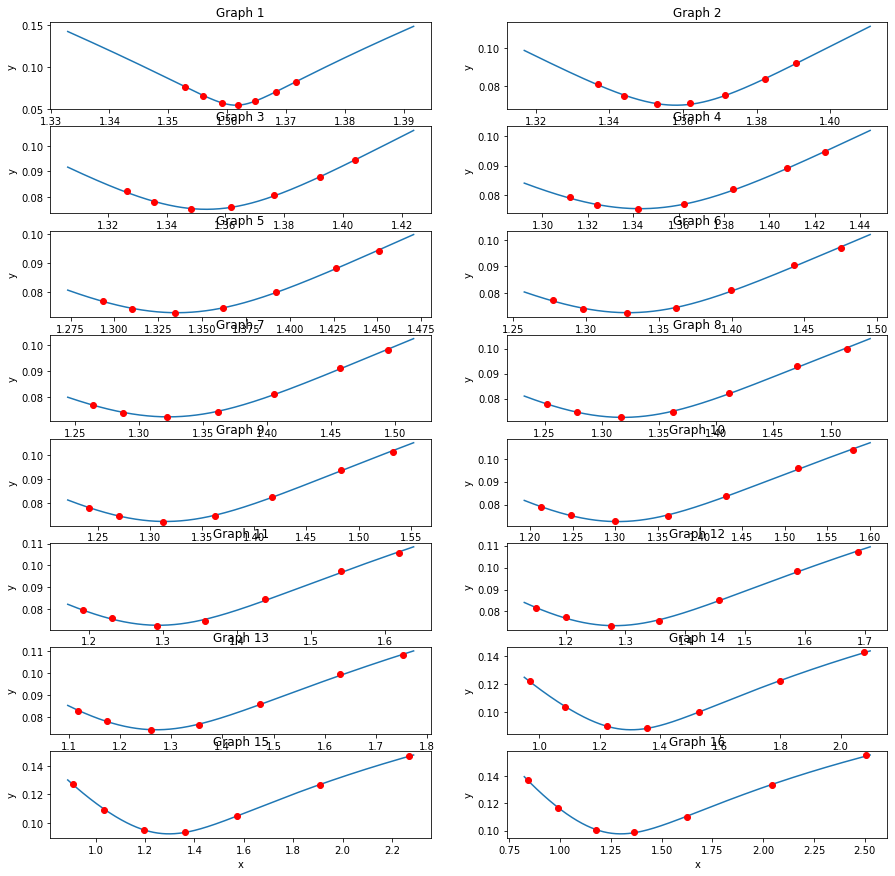

In [233]:
fitvol(vol,strikes,forward,t,'Hagan')

[ 0.05141698 16.86339699  0.06014462  0.99999956]
[0.06832223 4.74136441 0.12783346 0.99133487]
[0.07484356 2.90130498 0.16057836 0.95883051]
[0.07666741 1.80087295 0.2227619  0.93893115]
[0.07441411 1.35260422 0.23885873 0.9282023 ]
[0.07414572 1.16738904 0.25665609 0.92321764]
[0.07426346 1.0275503  0.26309311 0.9187767 ]
[9.86551485e-02 9.89624638e-01 3.40602782e-01 1.48941813e-18]
[0.09856344 0.92540537 0.34697114 0.00158057]
[9.84294122e-02 7.90522076e-01 3.67989193e-01 9.36750677e-17]
[9.80814029e-02 7.15881583e-01 3.83082114e-01 1.04972311e-18]
[0.09863659 0.59987674 0.38831511 0.00533035]
[0.09939501 0.5278628  0.39890772 0.00376101]
[0.09980675 0.54413453 0.22507422 0.32934662]
[0.10284951 0.46309308 0.21850241 0.40113759]
[0.10636237 0.41610005 0.19837588 0.46359599]


,alpha,nu,rho,beta
0.002740,0.051417,16.863397,0.060145,9.999996e-01
0.019178,0.068322,4.741364,0.127833,9.913349e-01
0.038356,0.074844,2.901305,0.160578,9.588305e-01
0.082192,0.076667,1.800873,0.222762,9.389311e-01
0.164384,0.074414,1.352604,0.238859,9.282023e-01
0.249315,0.074146,1.167389,0.256656,9.232176e-01
0.331507,0.074263,1.027550,0.263093,9.187767e-01
0.413699,0.098655,0.989625,0.340603,1.489418e-18
0.498630,0.098563,0.925405,0.346971,1.580568e-03
0.747945,0.098429,0.790522,0.367989,9.367507e-17


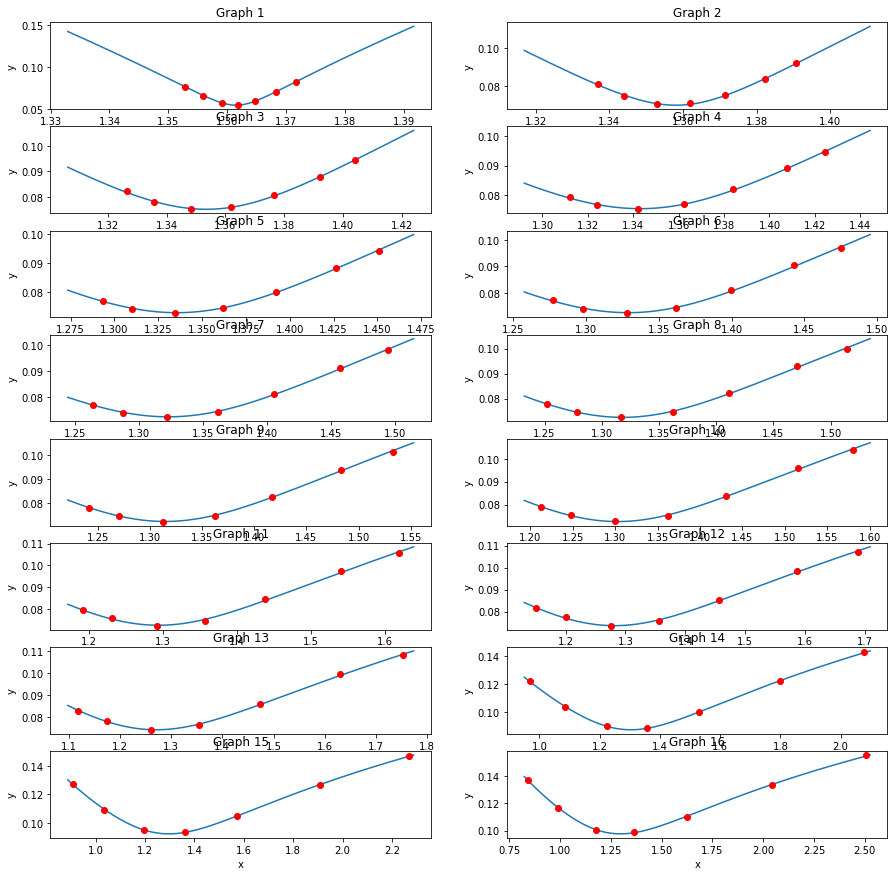

In [234]:
fitvol(vol,strikes,forward,t,'Obloj')